# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [45]:
import palmerpenguins
from palmerpenguins import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from plotnine import *
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder


In [46]:
penguin = load_penguins()
penguin = penguin.dropna()
penguin.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [47]:

label_encoder = LabelEncoder()
penguin['species_encoded'] = label_encoder.fit_transform(penguin['species'])

X = penguin.drop(columns=['species', 'species_encoded']) 
y = penguin['species_encoded']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [48]:
ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
        ("onehot", OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=["object", "category"]))
    ],
    remainder="passthrough" 
)
# kNN model with k=3
knn_3 = Pipeline(
    [("preprocessing", ct), ("knn", KNeighborsClassifier(n_neighbors=3))]
)
knn_3.fit(X_train, y_train)

# kNN model with k=5
knn_5 = Pipeline(
    [("preprocessing", ct), ("knn", KNeighborsClassifier(n_neighbors=5))]
)
knn_5.fit(X_train, y_train)

# Decision Tree with depth=3
dt_3 = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier(max_depth=3, random_state=42))
])
dt_3.fit(X_train, y_train)

# Decision Tree with depth=5
dt_5 = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier(max_depth=5, random_state=42))
])
dt_5.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x317815250>),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3178150a0>)])),
                ('decision_tree',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

Model: kNN (k=3)
Confusion Matrix:
[[40  0  0]
 [ 0 20  0]
 [ 0  0 24]]
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        40
   Chinstrap       1.00      1.00      1.00        20
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

AUC Scores: [1. 1. 1.]

Model: kNN (k=5)
Confusion Matrix:
[[40  0  0]
 [ 0 20  0]
 [ 0  0 24]]
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        40
   Chinstrap       1.00      1.00      1.00        20
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00      

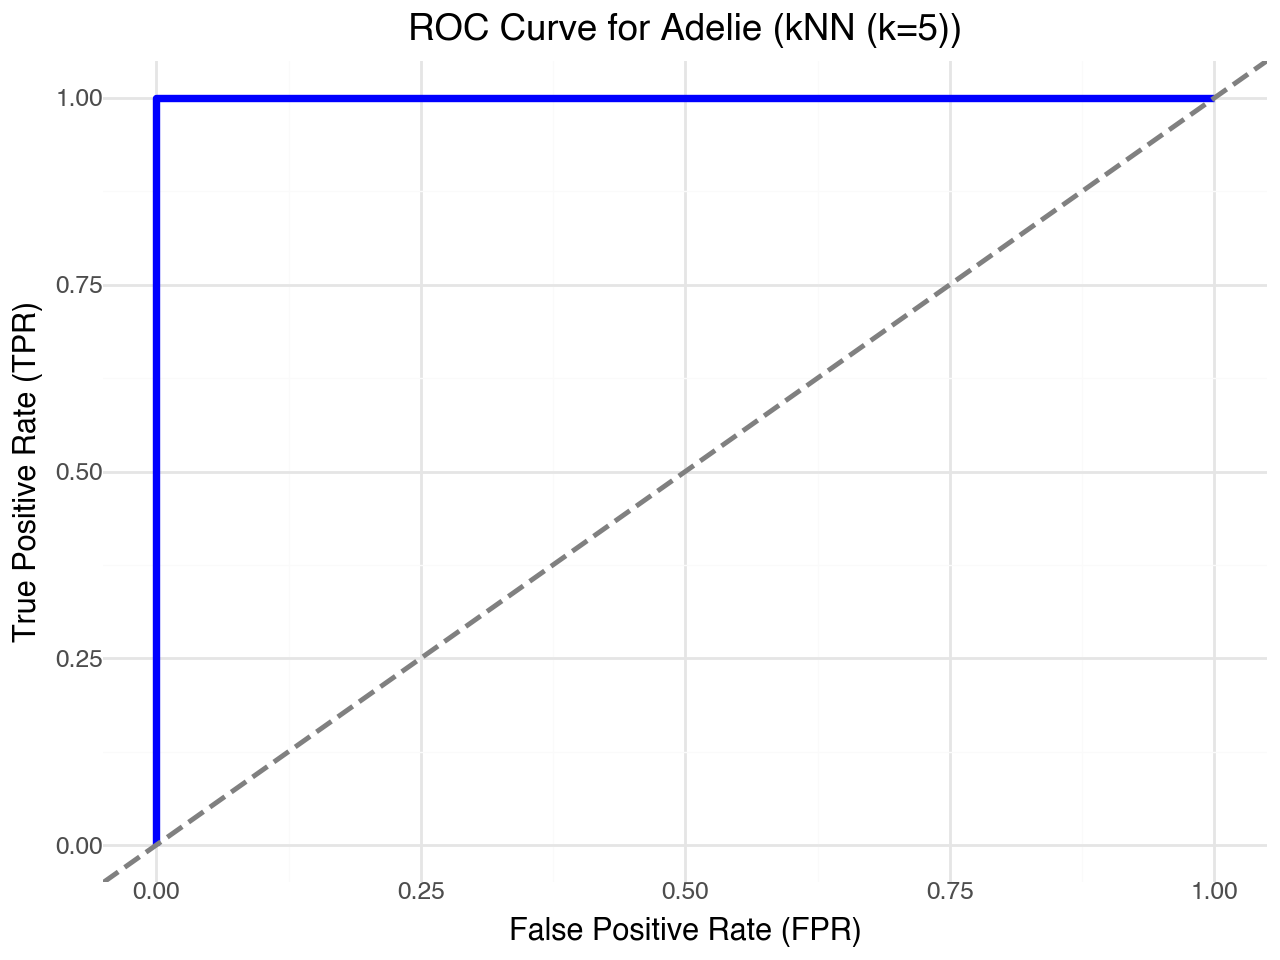

In [51]:
def evaluate_model(model, X_test, y_test, species_labels):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    report = classification_report(y_test, y_pred, target_names=species_labels)
    
    auc_scores = []
    for i in range(len(species_labels)):
        auc = roc_auc_score((y_test == i).astype(int), y_proba[:, i])
        auc_scores.append(auc)
    auc_scores = np.array(auc_scores)     
    
    return cm, accuracy, report, auc_scores, y_proba

species_labels = label_encoder.classes_
results = {}
for model_name, model in [("kNN (k=3)", knn_3), ("kNN (k=5)", knn_5),
                          ("DT (depth=3)", dt_3), ("DT (depth=5)", dt_5)]:
    cm, acc, report, auc_scores, y_proba = evaluate_model(model, X_test, y_test, species_labels)
    results[model_name] = {
        "Confusion Matrix": cm,
        "Accuracy": acc,
        "Report": report,
        "AUC": auc_scores,
        "y_proba": y_proba  
    }

for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Classification Report:\n{metrics['Report']}")
    print(f"AUC Scores: {metrics['AUC']}\n") 

model_name = "kNN (k=5)"
y_proba = results[model_name]['y_proba']
adelie_index = list(species_labels).index("Adelie")

y_proba_adelie = y_proba[:, adelie_index]
y_test_adelie = (y_test == adelie_index).astype(int)

fpr, tpr, thresholds = roc_curve(y_test_adelie, y_proba_adelie)

roc_df = pd.DataFrame({
    "FPR": fpr,
    "TPR": tpr
})

(
    ggplot(roc_df, aes(x="FPR", y="TPR")) +
    geom_line(color="blue", size=1.5) +
    geom_abline(intercept=0, slope=1, linetype="dashed", color="gray", size=1) +
    labs(
        title=f"ROC Curve for Adelie ({model_name})",
        x="False Positive Rate (FPR)",
        y="True Positive Rate (TPR)"
    ) +
    theme_minimal()
)